In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Input, BatchNormalization, LeakyReLU, Conv2DTranspose, Dropout, ReLU, Concatenate, ZeroPadding2D
import os
from glob import glob
from PIL import Image
import shutil
from tqdm import tqdm
import numpy as np
from tensorflow.data import AUTOTUNE

In [2]:
seed = 42
monet_path = './gan-getting-started/monet_tfrec/*.tfrec'
photo_path = './gan-getting-started/photo_tfrec/*.tfrec'
image_size = [256, 256]
monet_filenames = []
photo_filenames = []
batch_size = 1
epochs = 40
steps_per_epoch = 50

In [3]:
tf.random.set_seed(seed)
np.random.seed(seed)

In [4]:
monet_filenames = tf.io.gfile.glob(str(monet_path))
print('Monet TFRecord Files:', len(monet_filenames))

photo_filenames = tf.io.gfile.glob(str(photo_path))
print('Photo TFRecord Files:', len(photo_filenames))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


In [5]:
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*image_size, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

In [6]:
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

In [7]:
monet_ds = load_dataset(monet_filenames, labeled=True)
photo_ds = load_dataset(photo_filenames, labeled=True)

monet_ds = monet_ds.repeat().shuffle(300).batch(batch_size).prefetch(AUTOTUNE)
photo_ds = photo_ds.repeat().shuffle(7000).batch(batch_size).prefetch(AUTOTUNE)

In [8]:
example_monet = next(iter(monet_ds))
example_photo = next(iter(photo_ds))

2025-04-21 21:42:15.759489: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:381] TFRecordDataset `buffer_size` is unspecified, default to 262144


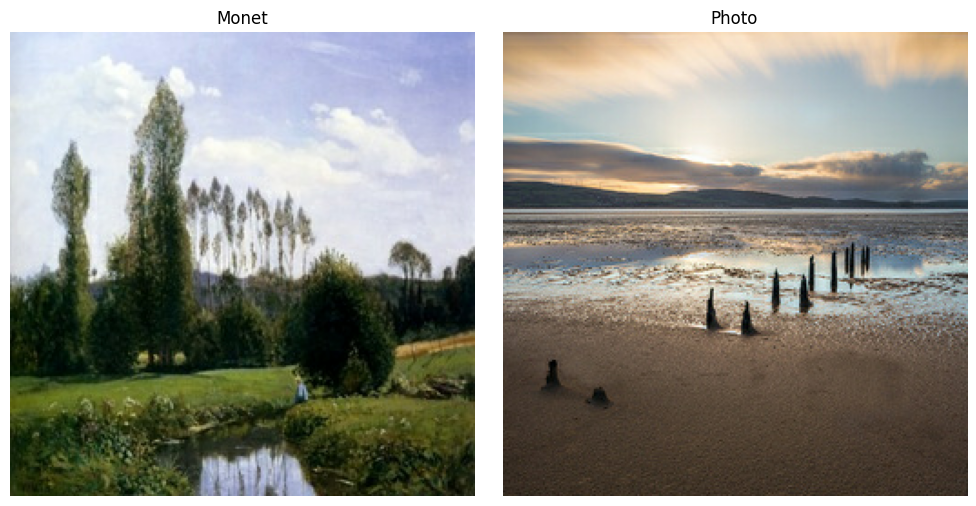

In [9]:
# Plot 1 image from each set
plt.figure(figsize=(10, 5))

# Monet image
ax = plt.subplot(1, 2, 1)
plt.imshow((example_monet[0].numpy() * 0.5 + 0.5))  # Unnormalize if in [-1, 1]
plt.title("Monet")
plt.axis("off")

# Photo image
ax = plt.subplot(1, 2, 2)
plt.imshow((example_photo[0].numpy() * 0.5 + 0.5))  # Unnormalize if in [-1, 1]
plt.title("Photo")
plt.axis("off")

plt.tight_layout()
plt.show()

The goal of this CycleGAN model is to perform unpaired image-to-image translation between two domains:

Photos (real-world images)
Monet paintings (art-style domain)
The model learns to translate photos to Monet-style images without needing 1-to-1 paired examples.

Why CycleGAN?
No need for paired images
Well-suited for style transfer tasks like
Proven success in artistic domain generation tasks
How It Works
CycleGAN uses:

Two generators:

G: Photo → Monet
F: Monet → Photo
Two discriminators:

D_Y: distinguishes real Monet paintings from generated ones
D_X: distinguishes real photos from generated ones
Model Architecture
Generator (G & F)

Based on U-Net

Consists of:

Downsampling (Conv + BatchNorm + LeakyReLU)
Residual blocks
Upsampling (Transposed Conv)
Discriminator (D_X & D_Y)

PatchGAN architecture
Judges authenticity over image patches, not the full image
Helps the model focus on local texture and style

Generators and Discriminators

In [10]:
def resnet_block(x, filters):
    init = x
    x = tf.keras.layers.Conv2D(filters, 3, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(filters, 3, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    return tf.keras.layers.add([x, init])

def resnet_generator():
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])
    x = tf.keras.layers.Conv2D(64, 7, padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.Conv2D(128, 3, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.Conv2D(256, 3, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    for _ in range(9):
        x = resnet_block(x, 256)

    x = tf.keras.layers.Conv2DTranspose(128, 3, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.Conv2DTranspose(64, 3, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.Conv2D(3, 7, padding='same', activation='tanh')(x)
    return tf.keras.Model(inputs=inputs, outputs=x)

def unet_generator():
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])

    # Encoder (downsampling)
    def down_block(x, filters, apply_batchnorm=True):
        x = tf.keras.layers.Conv2D(filters, 4, strides=2, padding='same', use_bias=False)(x)
        if apply_batchnorm:
            x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.LeakyReLU()(x)
        return x

    # Decoder (upsampling)
    def up_block(x, skip, filters, apply_dropout=False):
        x = tf.keras.layers.Conv2DTranspose(filters, 4, strides=2, padding='same', use_bias=False)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        if apply_dropout:
            x = tf.keras.layers.Dropout(0.5)(x)
        x = tf.keras.layers.ReLU()(x)
        x = tf.keras.layers.Concatenate()([x, skip])
        return x

    down1 = down_block(inputs, 64, apply_batchnorm=False)
    down2 = down_block(down1, 128)
    down3 = down_block(down2, 256)
    down4 = down_block(down3, 512)
    down5 = down_block(down4, 512)
    down6 = down_block(down5, 512)
    down7 = down_block(down6, 512)
    bottleneck = down_block(down7, 512)

    up1 = up_block(bottleneck, down7, 512, apply_dropout=True)
    up2 = up_block(up1, down6, 512, apply_dropout=True)
    up3 = up_block(up2, down5, 512, apply_dropout=True)
    up4 = up_block(up3, down4, 512)
    up5 = up_block(up4, down3, 256)
    up6 = up_block(up5, down2, 128)
    up7 = up_block(up6, down1, 64)

    last = tf.keras.layers.Conv2DTranspose(3, 4, strides=2, padding='same', activation='tanh')(up7)
    return tf.keras.Model(inputs=inputs, outputs=last)

def discriminator():
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])
    x = tf.keras.layers.Conv2D(64, 4, strides=2, padding='same')(inputs)
    x = tf.keras.layers.LeakyReLU(0.2)(x)

    x = tf.keras.layers.Conv2D(128, 4, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(0.2)(x)

    x = tf.keras.layers.Conv2D(256, 4, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(0.2)(x)

    x = tf.keras.layers.Conv2D(1, 4, padding='same')(x)
    return tf.keras.Model(inputs=inputs, outputs=x)

# ---------- Loss Functions ----------
loss_obj = tf.keras.losses.MeanSquaredError()

def generator_loss(fake):
    return loss_obj(tf.ones_like(fake), fake)

def discriminator_loss(real, fake):
    real_loss = loss_obj(tf.ones_like(real), real)
    fake_loss = loss_obj(tf.zeros_like(fake), fake)
    return (real_loss + fake_loss) * 0.5

def cycle_loss(real, cycled, lambda_cycle):
    return tf.reduce_mean(tf.abs(real - cycled)) * lambda_cycle

def identity_loss(real, same, lambda_cycle, lambda_identity):
    return tf.reduce_mean(tf.abs(real - same)) * lambda_cycle * lambda_identity

# === FID Calculation ===
def calculate_fid(real, generated):
    real = (real + 1.0) * 127.5
    generated = (generated + 1.0) * 127.5
    fid = tfgan.eval.frechet_inception_distance(
        tfgan.eval.run_inception(real, output_tensor='pool_3'),
        tfgan.eval.run_inception(generated, output_tensor='pool_3')
    )
    return fid.numpy()


def generate_images(model, test_input):
    """Generates and displays images side-by-side (real vs. fake)."""
    prediction = model(test_input, training=False)
    prediction = (prediction[0] + 1) / 2  # scale to [0,1]
    test_input = (test_input[0] + 1) / 2

    plt.figure(figsize=(8, 4))
    display_list = [test_input, prediction]
    title = ['Input Photo', 'Generated Monet']

    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [11]:
# === Hyperparameters ===
early_stopping_patience = 3  # Number of epochs to wait before early stopping
fid_frequency = 5  # Calculate FID every 5 epochs

# Lambda values to tune
lambda_cycle_values = [5.0, 10.0]
lambda_identity_values = [0.5, 1.0]

In [12]:
# === Model Setup ===
def create_models(gen_type='resnet'):
    # Pick generator type
    if gen_type == 'resnet':
        generator_g = resnet_generator()
        generator_f = resnet_generator()
    elif gen_type == 'unet':
        generator_g = unet_generator()
        generator_f = unet_generator()
    else:
        raise ValueError("gen_type must be 'resnet' or 'unet'")

    # Discriminators
    discriminator_x = discriminator()
    discriminator_y = discriminator()

    return generator_g, generator_f, discriminator_x, discriminator_y

# === Optimizers ===
def create_optimizers():
    gen_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    gen_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    disc_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    disc_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
    return gen_g_optimizer, gen_f_optimizer, disc_x_optimizer, disc_y_optimizer

In [13]:
# === Training Step ===
@tf.function
def train_step(real_x, real_y, generator_g, generator_f, discriminator_x, discriminator_y, 
               gen_g_optimizer, gen_f_optimizer, disc_x_optimizer, disc_y_optimizer, lambda_cycle, lambda_identity):
    with tf.GradientTape(persistent=True) as tape:
        # Generate fake images
        fake_y = generator_g(real_x, training=True)
        cycled_x = generator_f(fake_y, training=True)

        fake_x = generator_f(real_y, training=True)
        cycled_y = generator_g(fake_x, training=True)

        same_x = generator_f(real_x, training=True)
        same_y = generator_g(real_y, training=True)

        # Discriminator predictions
        disc_real_x = discriminator_x(real_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)

        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)

        # Generator losses
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)

        total_cycle_loss = cycle_loss(real_x, cycled_x, lambda_cycle) + \
                           cycle_loss(real_y, cycled_y, lambda_cycle)

        id_loss = identity_loss(real_x, same_x, lambda_cycle, lambda_identity) + \
                  identity_loss(real_y, same_y, lambda_cycle, lambda_identity)

        total_gen_g_loss = gen_g_loss + total_cycle_loss + id_loss
        total_gen_f_loss = gen_f_loss + total_cycle_loss + id_loss

        # Discriminator losses
        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

    # Compute gradients
    gen_g_gradients = tape.gradient(total_gen_g_loss, generator_g.trainable_variables)
    gen_f_gradients = tape.gradient(total_gen_f_loss, generator_f.trainable_variables)
    disc_x_gradients = tape.gradient(disc_x_loss, discriminator_x.trainable_variables)
    disc_y_gradients = tape.gradient(disc_y_loss, discriminator_y.trainable_variables)

    # Apply gradients
    gen_g_optimizer.apply_gradients(zip(gen_g_gradients, generator_g.trainable_variables))
    gen_f_optimizer.apply_gradients(zip(gen_f_gradients, generator_f.trainable_variables))
    disc_x_optimizer.apply_gradients(zip(disc_x_gradients, discriminator_x.trainable_variables))
    disc_y_optimizer.apply_gradients(zip(disc_y_gradients, discriminator_y.trainable_variables))

    return {
        'G_G': gen_g_loss,
        'G_F': gen_f_loss,
        'Cycle': total_cycle_loss,
        'Identity': id_loss,
        'D_X': disc_x_loss,
        'D_Y': disc_y_loss,
    }

In [14]:
# === Visualization of Sample Image ===
def generate_images(generator_g, sample_photo):
    # Generate a fake image from the photo generator
    fake_image = generator_g(sample_photo, training=False)
    # Visualize the original and generated image side by side
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Real Photo")
    plt.imshow((sample_photo[0].numpy() + 1.0) * 127.5 / 255.0)  # Rescale image for visualization
    plt.subplot(1, 2, 2)
    plt.title("Generated Monet")
    plt.imshow((fake_image[0].numpy() + 1.0) * 127.5 / 255.0)  # Rescale image for visualization
    plt.show()


In [15]:
# === Early Stopping and FID Tracking ===
def train_cyclegan(monet_ds, photo_ds, lambda_cycle_values, lambda_identity_values, fid_scores, loss_history, epochs=40, fid_frequency=5, gen_type='resnet'):
    best_fid = float('inf')
    patience = 0

    # Preload test image for visualization
    sample_photo = next(iter(photo_ds.take(1)))

    # Try different lambda values (hyperparameter tuning)
    for lambda_cycle in lambda_cycle_values:
        for lambda_identity in lambda_identity_values:
            print(f"Training with lambda_cycle={lambda_cycle}, lambda_identity={lambda_identity}")
            
            # Create the models and optimizers
            generator_g, generator_f, discriminator_x, discriminator_y = create_models(gen_type)
            gen_g_optimizer, gen_f_optimizer, disc_x_optimizer, disc_y_optimizer = create_optimizers()

            # Training loop
            for epoch in range(epochs):
                print(f"\n🔁 Epoch {epoch+1}/{epochs}")
                step_ds = tf.data.Dataset.zip((photo_ds, monet_ds)).take(steps_per_epoch)
                pbar = tqdm(step_ds, total=steps_per_epoch)

                for real_x, real_y in pbar:
                    losses = train_step(real_x, real_y, generator_g, generator_f, discriminator_x, discriminator_y, 
                                        gen_g_optimizer, gen_f_optimizer, disc_x_optimizer, disc_y_optimizer, 
                                        lambda_cycle, lambda_identity)
                    pbar.set_description(f"G: {losses['G_G']:.3f} | C: {losses['Cycle']:.3f} | D: {losses['D_X']:.3f}")
                
                # Store losses
                for k in loss_history.keys():
                    loss_history[k].append(float(losses[k]))
                
                # FID calculation every fid_frequency epochs
                if (epoch + 1) % fid_frequency == 0:
                    fid_score = calculate_fid(real_x, fake_y)  # Use fake_y from the last training batch
                    print(f"  FID at epoch {epoch+1}: {fid_score:.4f}")
                    fid_scores.append(fid_score)
                    
                    # Early stopping based on FID
                    if fid_score < best_fid:
                        best_fid = fid_score
                        patience = 0
                        # Save the best model here if needed
                    else:
                        patience += 1
                        if patience >= early_stopping_patience:
                            print(f"Early stopping at epoch {epoch+1} due to no improvement in FID")
                            break
                
                # Show sample image every 10 epochs
                if (epoch + 1) % 10 == 0:
                    print("📷 Sample Output:")
                    generate_images(generator_g, sample_photo)


In [16]:
def plot_fid_scores(fid_scores):
    plt.figure(figsize=(10, 5))
    plt.plot(range(len(fid_scores)), fid_scores, marker='o')
    plt.title('FID Score Over Epochs')
    plt.xlabel('Checkpoints (every n epochs)')
    plt.ylabel('FID Score')
    plt.grid(True)
    plt.show()

In [17]:
def plot_loss_curves(loss_history):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(loss_history['gen_g'], label='Gen G')
    plt.plot(loss_history['gen_f'], label='Gen F')
    plt.plot(loss_history['cycle'], label='Cycle')
    plt.plot(loss_history['identity'], label='Identity')
    plt.title('Generator Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(loss_history['disc_x'], label='Disc X')
    plt.plot(loss_history['disc_y'], label='Disc Y')
    plt.title('Discriminator Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


In [18]:
loss_history = {
    'G_G': [],
    'G_F': [],
    'Cycle': [],
    'Identity': [],
    'D_X': [],
    'D_Y': []
}
fid_scores = []  # Append every 5 epochs
train_cyclegan(monet_ds, photo_ds, lambda_cycle_values, lambda_identity_values, fid_scores, loss_history, epochs=40, fid_frequency=5, gen_type="resnet")
plot_fid_scores(fid_scores)
plot_loss_curves(loss_history)

Training with lambda_cycle=5.0, lambda_identity=0.5

🔁 Epoch 1/40


G: 0.335 | C: 2.698 | D: 0.243: 100%|██████████| 50/50 [07:20<00:00,  8.85s/it]2025-04-21 21:49:40.686350: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
G: 0.335 | C: 2.698 | D: 0.243: 100%|██████████| 50/50 [07:20<00:00,  8.81s/it]



🔁 Epoch 2/40


G: 0.286 | C: 2.356 | D: 0.268:  10%|█         | 5/50 [00:59<08:59, 12.00s/it]


KeyboardInterrupt: 

In [ ]:
loss_history = {
    'G_G': [],
    'G_F': [],
    'Cycle': [],
    'Identity': [],
    'D_X': [],
    'D_Y': []
}
fid_scores = []
train_cyclegan(monet_ds, photo_ds, lambda_cycle_values, lambda_identity_values, fid_scores, loss_history, epochs=40, fid_frequency=5, gen_type="unet")
lot_fid_scores(fid_scores)
plot_loss_curves(loss_history)